In [46]:
import os
import numpy as np
import tifffile as tiff
from PIL import Image

images_path = "/content/drive/MyDrive/satalite data/data/images"
labels_path = "/content/drive/MyDrive/satalite data/data/labels"


image_files = sorted([f for f in os.listdir(images_path) if f.endswith(".tif")])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith(".png")])

label_dict = {os.path.splitext(f)[0]: f for f in label_files} # dictionary has all labels for one image

X, Y = [], []

for img_file in image_files:
    base = os.path.splitext(img_file)[0]

    img = tiff.imread(os.path.join(images_path, img_file)).astype(np.float32)

    for c in range(img.shape[-1]):
        band = img[..., c]
        img[..., c] = (band - band.min()) / (band.max() - band.min() + 1e-6)

    X.append(img)

    # Only take mask with the exact same name
    if base in label_dict:
        lbl_file = label_dict[base]
        mask = np.array(Image.open(os.path.join(labels_path, lbl_file)).convert("L"))
    else:
        mask = np.zeros(img.shape[:2], dtype=np.uint8)

    Y.append(mask)

X = np.array(X)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128)


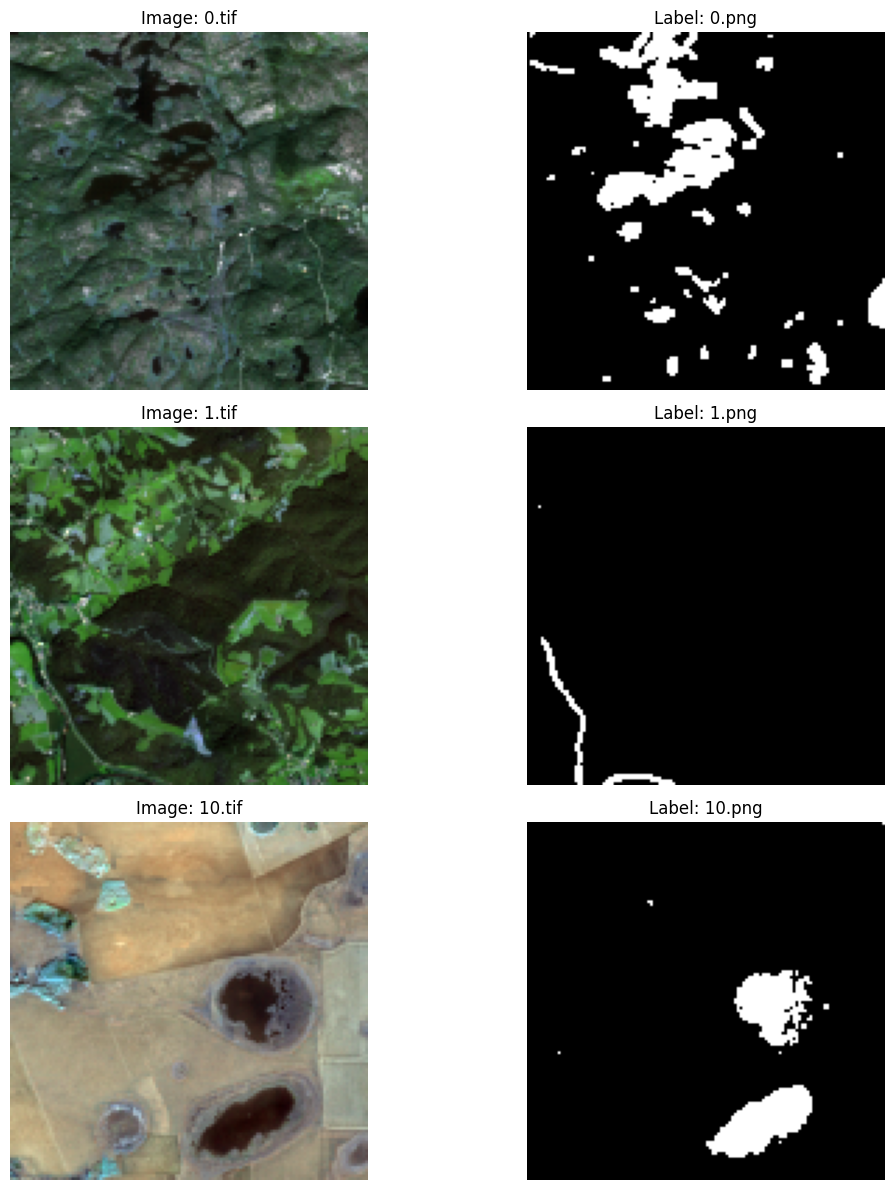

In [47]:
import matplotlib.pyplot as plt
from PIL import Image


def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

N = 3
plt.figure(figsize=(12, N*4))

for idx in range(N):

    img = tiff.imread(os.path.join(images_path, image_files[idx]))


    rgb = img[..., 1:4]


    rgb_norm = np.zeros_like(rgb, dtype=np.float32)

    for c in range(3):
        rgb_norm[..., c] = normalize(rgb[..., c])


    lbl = np.array(Image.open(os.path.join(labels_path, label_files[idx])).convert("L"))


    plt.subplot(N, 2, 2*idx + 1)
    plt.imshow(rgb_norm)
    plt.title(f"Image: {image_files[idx]}")
    plt.axis("off")

    plt.subplot(N, 2, 2*idx + 2)
    plt.imshow(lbl, cmap="gray")
    plt.title(f"Label: {label_files[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


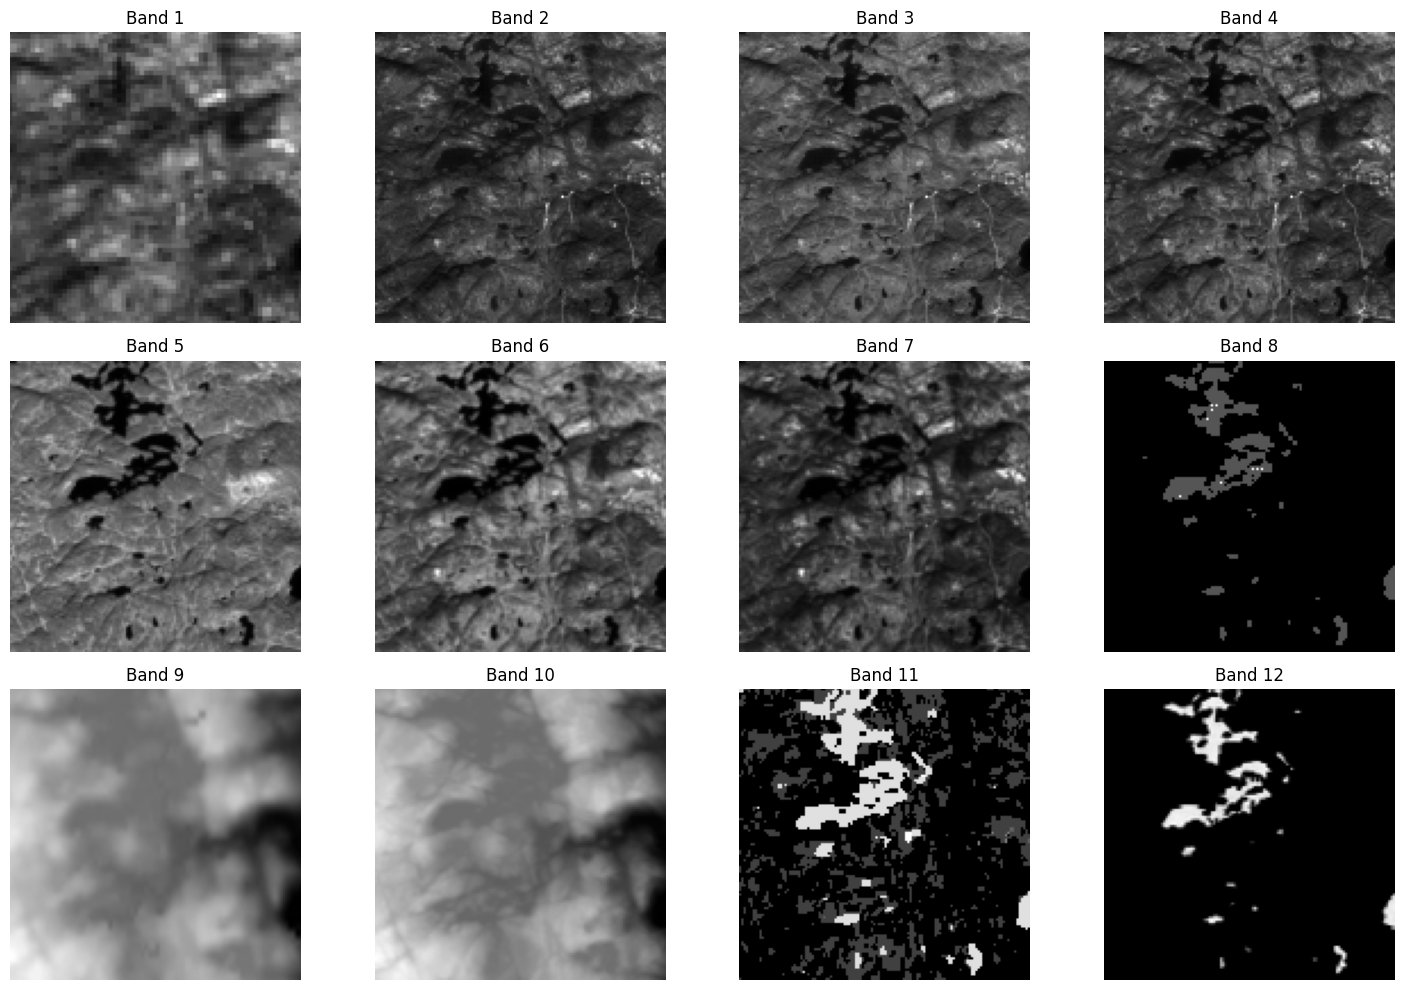

In [49]:
img = tiff.imread(os.path.join(images_path, image_files[0])).astype(float)

num_bands = img.shape[-1]
plt.figure(figsize=(15, 10))

for b in range(num_bands):
    plt.subplot(3, 4, b+1)
    plt.imshow(img[..., b], cmap="gray")
    plt.title(f"Band {b+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


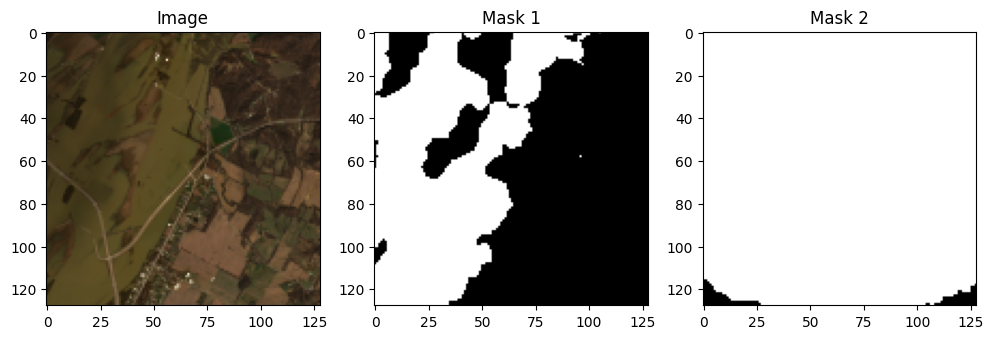

In [50]:
import matplotlib.pyplot as plt

img = tiff.imread(os.path.join(images_path, "9.tif"))
rgb = img[..., 1:4]
mask1 = np.array(Image.open(os.path.join(labels_path, "9.png")).convert("L"))
mask2 = np.array(Image.open(os.path.join(labels_path, "9_202.png")).convert("L"))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(rgb[...,::-1]/rgb.max()); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(mask1, cmap="gray"); plt.title("Mask 1")
plt.subplot(1,3,3); plt.imshow(mask2, cmap="gray"); plt.title("Mask 2")
plt.show()


# Model Architecture

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c4)

    # Decoder (Upsampling)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c5)

    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(c7)

    # Output layer (1 channel for binary segmentation)
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      1,744 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_30[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_32[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_34[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │    147,712 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_36[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 32, 32,    │     65,600 │ conv2d_37[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     73,792 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 64, 64,    │      8,224 │ conv2d_39[0][0] 

 Total params: 1,032,449 (3.94 MB)

 Trainable params: 1,032,449 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

model.compile(optimizer="adam" , loss = "binary_crossentropy" , metrics=["accuracy"])

history = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_valid, Y_valid))


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - accuracy: 0.6009 - loss: 0.6504 - val_accuracy: 0.8838 - val_loss: 0.4325
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8602 - loss: 0.4447 - val_accuracy: 0.9018 - val_loss: 0.2753
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8960 - loss: 0.2886 - val_accuracy: 0.9061 - val_loss: 0.2577
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8909 - loss: 0.2835 - val_accuracy: 0.9098 - val_loss: 0.2405
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8855 - loss: 0.2977 - val_accuracy: 0.9071 - val_loss: 0.2407
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8952 - loss: 0.2801 - val_accuracy: 0.9111 - val_loss: 0.2436
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8912 - loss: 0.2771 - val_accuracy: 0.9128 - val_loss: 0.2244
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8943 - loss: 0.2649 - val_accuracy: 0.9132 

In [58]:
from tensorflow.keras.metrics import Precision , Recall , IoU , F1Score


y_pred = model.predict(X_valid)


y_pred_binary = np.squeeze((y_pred > 0.5).astype(np.uint8))

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(Y_valid, y_pred_binary)
recall.update_state(Y_valid, y_pred_binary)

print("Precision:", precision.result().numpy())
print("Recall:", recall.result().numpy())



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Precision: 0.934074
Recall: 0.67288536


In [59]:
intersection = np.logical_and(Y_valid, y_pred_binary)
union = np.logical_or(Y_valid, y_pred_binary)
iou = np.sum(intersection) / np.sum(union)

prec_val = precision.result().numpy()
rec_val = recall.result().numpy()
f1 = 2 * (prec_val * rec_val) / (prec_val + rec_val + 1e-7)

print("IoU:", iou)

print("F1 Score:", f1)

IoU: 0.6423778367917968
F1 Score: 0.7822534


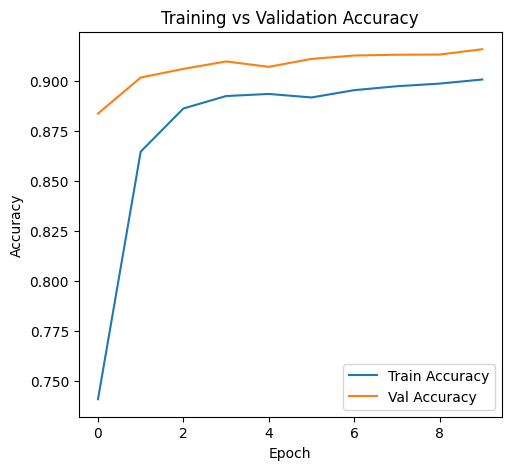

In [60]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))

    # --- Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()

# Call it after training
plot_history(history)


In [64]:
# save the model
save_path = "/content/drive/MyDrive/Colab Notebooks/model.keras"
model.save(save_path)